# set up environment

In [1]:
%matplotlib inline
%pdb off

Automatic pdb calling has been turned OFF


In [0]:
import numpy as np
import scipy as sp
from scipy import linalg as la
from scipy import optimize as op
import matplotlib as mpl
import pylab as plt
import sympy as sym

In [3]:
!pip install control
import control as ctrl

    100% |████████████████████████████████| 174kB 4.5MB/s 
  Running setup.py bdist_wheel for control ... - \ done
  Stored in directory: /root/.cache/pip/wheels/d2/8f/04/16760efa8227635eced77a90b880f874bfbb7c91d6272bda14
Successfully built control


In [0]:
def D(g,y,d=1e-4):
  """
  approximate derivative via finite-central-differences 

  input:
    g - function - g : R^n -> R^m
    y - n array
    (optional)
    d - scalar - finite differences displacement parameter

  output:
    Dg(y) - m x n - approximation of Jacobian of g at y
  """
  # given $g:\mathbb{R}^n\rightarrow\mathbb{R}^m$:
  # $$D_y g(y)e_j \approx \frac{1}{2\delta}(g(y+\delta e_j) - g(y - \delta e_j)),\ \delta\ll 1$$
  e = np.identity(len(y))
  Dyg = []
  for j in range(len(y)):
      Dyg.append((.5/d)*(g(y+d*e[j]) - g(y-d*e[j])))
  return np.array(Dyg).T

def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(x,u) 

  input:
    f : R x X x U --> X - vector field
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

def psi(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None):
  """
  simulate x' = f(x,u) using forward Euler algorithm, return final state

  input:
    f : R x X x U --> X - vector field
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    x(t) - X array - final state 
  """
  t_,x_ = numerical_simulation(f,t,x,t0=t0,dt=dt,ut=ut,ux=ux,utx=utx)
  return x_[-1]

# scratch

## control canonical form

a. Transcribe the $n$-th order scalar differential equation with constant coefficients

$$ \frac{d^n}{dt^{n}} y + a_1 \frac{d^{n-1}}{dt^{n-1}} y + \cdots a_n = b u $$

into a single-input, single-output (SISO) state-space DE with $x = (\frac{d^{n-1}}{dt^{n-1}} y, \dots, y)$, i.e. determine matrices $A,B,C,D$ (and specify their shapes) such that 

$$ \dot{x} = A x + B u,\ y = C x + D u. $$

b. Apply linear state feedback $u = - K x$ to the state-space DE from (a.) and provide an expression for the closed-loop system matrix $A - BK$.

c. Determine the characteristic polynomial for the closed-loop system matrix from (b.).

d. Describe how you would choose the entries of the feedback gain matrix $K$ to place the closed-loop system eigenvalues at $\{\lambda_i\}_{i=1}^n\subset\mathbb{C}$.

# cruise control

Force balance on car chassis yields

$$ m \dot{v} = F - F_d $$

where:
* $m$ is mass of car, passengers, and load;
* $v$ is velocity / speed of car;
* $F$ is engine force, which is proportional to control signal $0 \le u \le 1$ that specifies throttle position (that, in turn, specifies fuel injection rate), and varies nonlinearly with engine (angular) speed $\omega$,

* * $ F = \frac{R u}{r} T(\omega),\ \omega = \frac{R}{r} v, $

* * $ T(\omega) = T_m \cdot \left( 1 - \beta \cdot \left( \frac{\omega}{\omega_m} - 1 \right)^2 \right), $

* * $T_m$ is the maximum engine torque (supplied at speed $\omega_m$), $R$ is the gear ratio, and $r$ is the wheel radius;

* $F_d = F_g + F_r + F_a$ is disturbance force where:
* * $F_g = m g \sin\theta$ is the fraction of gravitational acceleration $g$ converted to gravitational force when the road has slope $\theta$;
* * $F_r = m g C_r \frac{v}{|v|}$ is the rolling / road frictional force with coefficient of friction $C_r$;
* * $F_a = \frac{1}{2} \rho C_d A |v| v$ is the aerodynamic drag force from air density $\rho$, frontal car area $A$, and (shape-dependent) coefficient of aerodynamic drag $C_d$.

Taken together, we have a nonlinear differential equation that relates control input $u$ to the rate of change in car velocity $v$:

$$ m \dot{v} = \frac{R}{r} u T\left(\frac{R}{r} v \right) - m g \sin\theta - m g C_r \frac{v}{|v|} - \frac{1}{2} \rho C_d A |v| v. $$

In [0]:
# parameter chosen by hand to make plot match [AMv2 Fig 4.3]
m = 4500. # kg
# parameter values from [AMv2 Ch 4.1]
alpha_n = 40
r = 0.5 # m 
R = alpha_n * r
T_m = 190 # Nm
beta = 0.4
omega_m = 420 # rad/sec ~= 4000 RPM
g = 9.8 # m / sec^2
C_r = 0.01
rho = 1.3 # kg / m^3
C_d = 0.32
A = 2.4 # m^2

# proportional-integral controller parameters
k_P = 0.5
k_I = 0.1

# reference velocity -- can vary over time
v_r = lambda t : 20. * np.ones_like(t) # m / sec

# road slope increases by 4 deg at time 5 sec
theta = lambda t : 4 * (np.pi/180) * (t >= 5.) # rad

In [0]:
# engine torque depends on engine (rotational) velocity
def T(omega):
  return T_m * (1 - beta * (omega / omega_m - 1.)**2)

# differential equation satisfied by car velocity:  \dot{v} = f(v,u)
def dv(t,v,u): 
  return (1./m) * ((R/r) * u * T((R/r) * v)         # F
                   - m * g * np.sin(theta(t))          # F_g
                   - m * g * C_r * v / np.abs(v)    # F_r
                   - (1./2) * rho * C_d * A * v**2) # F_a

# differential equation satisfied by proportional-integral controller state
def dz(t,v):
  return v_r(t) - v

# proportional-integral controller
def u(t,v,z):
  return k_P * (v_r(t) - v) + k_I * z

In [5]:
# initialize at reference velocity
v0 = v_r(0.) # m / sec

# integrator state that makes v0 an equilibrium
u0 = op.root(lambda u : dv(0.,v0,u),0.)['x'][0]
z0 = u0 / k_I

# controlled system state consists of car velocity and error integral
x0 = np.asarray([v0,z0])

def f(t,x):
  v,z = x
  return np.asarray([dv(t,v,u(t,v,z)),dz(t,v)])

print('x0 an equilibrium? ',np.allclose(f(0.,x0),0.))

x0 an equilibrium?  True


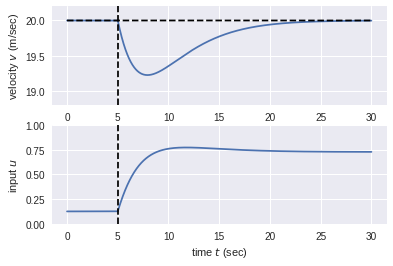

In [8]:
t = 30. # sec; simulation duration

t_,x_ = numerical_simulation(f,t,x0)

v_,z_ = x_.T

plt.figure()

ax = plt.subplot(2,1,1)
ylim = (18.8,20.2)
ax.plot(t_,v_)
ax.plot(5.*np.ones(2),ylim,'k--')
ax.plot(t_,v_r(t_),'k--')
ax.set_ylim(ylim)
ax.set_ylabel(r'velocity $v$ (m/sec)')


ax = plt.subplot(2,1,2)
ylim = (0.,1.)
ax.plot(t_,u(t_,v_,z_))
ax.plot(5.*np.ones(2),ylim,'k--')
ax.set_ylim(ylim)
ax.set_ylabel(r'input $u$')

ax.set_xlabel(r'time $t$ (sec)'); # semicolon suppresses text printout

# predator/prey

Letting
$L(t)$ 
denote number of lynxes (predators)
and
$H(t)$ 
denote number of hares (prey),
the population dynamics are
$$\dot{H} = r H \left( 1 - \frac{H}{k} \right) - \frac{a H L}{c + H},\ H \ge 0,$$
$$\dot{L} = b \frac{a H L}{c + H} - d L,\ L \ge 0,$$
where:
* $r$ is growth rate of hares,
* $k$ is maximum hare population (in absence of lynxes),
* $a$ is consumption rate of hares as lynx population increases,
* $c$ limits prey consumption rate at low population,
* $b$ is grown coefficient of lynxes,
* $d$ is mortality rate of lynxes.

In [59]:
# use symbolic algebra to find equilibria
r,k,a,c,b,d = sym.symbols(r'r,k,a,c,b,d')
t,H,L = sym.symbols(r't,H,L')

dH = r * H * (1 - H / k) - a * H * L / (c + H)
dL = b * a * H * L / (c + H) - d * L

eqs = [dict(zip([H,L],eq)) for eq in sym.simplify(sym.solve([dH,dL],[H,L]))]
print(eqs)

[{H: 0, L: 0}, {H: k, L: 0}, {H: c*d/(a*b - d), L: -b*c*r*(-a*b*k + c*d + d*k)/(k*(a*b - d)**2)}]


We find three equilibria:
$$(H^*,L^*) = (0,0),\ (H^*,L^*) = (k,0),$$
$$(H^*,L^*) = \left(\frac{c d}{a b - d}, \frac{b c r (a b k - c d - d k)}{k (a b - d)^2}\right)$$
The first two correspond to the uninteresting / ecologically undesirable situation where there are no predators (and possibly no prey), so we'll focus on the third.

In [0]:
eq = eqs[2]

p = {a:3.2, b:0.6, c:50, d:0.56, k:125, r:1.6}

x = (H,L)
dx = sym.Matrix([dH,dL])

f = sym.lambdify((t,x),dx.subs(p))

(-5.0, 105.0)

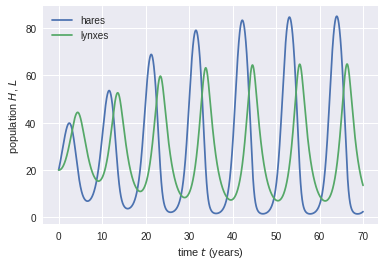

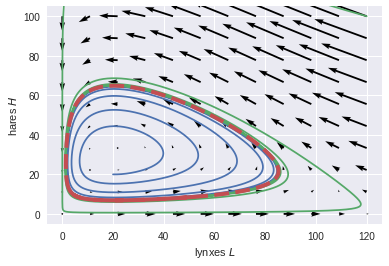

In [82]:

t = 70. # sec; simulation duration

x0 = np.asarray([20,20])

t_,x_ = numerical_simulation(lambda t,x : f(t,x).flatten(),t,x0,dt=1e-2)

H_,L_ = x_.T

# time trajectory
plt.figure()

ax = plt.subplot(1,1,1)
ax.plot(t_,H_,label='hares')
ax.plot(t_,L_,label='lynxes')
ax.legend()
ax.set_ylabel(r'population $H$, $L$')
ax.set_xlabel(r'time $t$ (years)')


# phase portrait / "quiver" plot
plt.figure()

H, L = np.meshgrid(np.linspace(0, 120, 12), np.linspace(0, 100, 10))
dH,dL = np.asarray([f(0.,(h,l)).flatten() for h,l in zip(H.flatten(),L.flatten())]).T
dH,dL = dH.reshape(H.shape),dL.reshape(L.shape)

ax = plt.subplot(1,1,1)
ax.plot(H_,L_)
ax.set_ylabel(r'hares $H$')
ax.set_xlabel(r'lynxes $L$')
ax.quiver(H,L,dH,dL)
ylim = ax.get_ylim()

x0 = np.asarray([120,100])
t_,x_ = numerical_simulation(lambda t,x : f(t,x).flatten(),t,x0,dt=1e-2)
H_,L_ = x_.T
ax.plot(H_,L_)
ax.plot(H_[-t_.size//5:],L_[-t_.size//5:],'--',lw=4)
ax.set_ylim(ylim)


# genetic circuit

In [0]:
# use symbolic algebra to find equilibria
alpha0,alpha,k,delta,kappa,gamma = sym.symbols(r'\alpha_0,\alpha,k,\delta,\kappa,\gamma')
t,m,p = sym.symbols(r't,m,p',positive=True)

dm = alpha0 + (alpha * p**2) / (1 + k * p**2) - delta * m
dp = kappa * m - gamma * p


In [6]:
dm,dp

(\alpha*p**2/(k*p**2 + 1) + \alpha_0 - \delta*m, -\gamma*p + \kappa*m)

In [0]:
meq = {m:sym.solve(dp,m)[0]}

In [17]:
sym.simplify((1 + k*p**2) * dm.subs(meq))

(\alpha*\kappa*p**2 + \alpha_0*\kappa*(k*p**2 + 1) - \delta*\gamma*p*(k*p**2 + 1))/\kappa

In [20]:
sym.Poly(sym.simplify((1 + k*p**2) * dm.subs(meq)),p)

Poly(-\delta*\gamma*k/\kappa*p**3 + (\alpha + \alpha_0*k)*p**2 - \delta*\gamma/\kappa*p + \alpha_0, p, domain='ZZ(k,\alpha,\alpha_0,\delta,\gamma,\kappa)')

In [0]:
sym.coeff

In [7]:
sym.solve([dm,dp],[m,p])

KeyboardInterrupt: ignored

In [0]:
eqs = [dict(zip([m,p],eq)) for eq in sym.simplify(sym.solve([dm,dp],[m,p]))]
print(eqs)